In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown
from sympy.physics import mechanics

# This is a custom interface to the pybullet simulator
import ae353_cmg

# For the notebook to "reload" the CMG script
import importlib
importlib.reload(ae353_cmg)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Jan 28 2022 20:18:15


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_cmg.Simulator(
    display=False,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

In [3]:
# Define parameter values

# one principal moment of inertia of the platform
J1 = 0.5 # kg*m^2

# two principal moments of inertia of the gimbal
J2 = 0.001 # kg*m^2

# principal moments of inertia of the rotor
J3 = 0.01 # kg*m^2

# mass of the boom
m = 1. # kg

# length of the boom
r = 2. # m

# acceleration due to gravity
g = 9.81 # m/s^2

# velocity of rotor
v_rotor = 1000.


# composite parameters
a1 = -J3 + 2*J3
a2 = 2.*J3
a3 = -2.*g*m*r
a4 = 2.*J1 + 2.*J2 + 2.*m*r**2.
a5 = 2.*J3
a6 = (J3 - J3)/(2*(J2 + J3))
a7 = -J3/(J2 + J3)
a8 = 1./(J2 + J3)

In [4]:
# Define a function to return a state-space model for a given choice of equilibrium point.
def get_model(q1e, v1e, q2e, v2e, taue):
    # Define variables
    q1, v1, q2, v2, tau = sym.symbols('q1, v1, q2, v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1, 
        ((a1 * sym.sin(2 * q2) * v1 * v2) + (a2 * sym.cos(q2) * v2 * v_rotor) + (a3) * sym.sin(q1)) / (a4 + (a5 * sym.cos(q2)**2)),
        v2,
        a6 * sym.sin(2 * q2) * v1**2 + a7 * sym.cos(q2) * v1 * v_rotor + a8 * tau
    ])
    
    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, q2, v2, tau], f)
    if not np.allclose(f_num(q1e, v1e, q2e, v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1, q2, v2])
    B_sym = f.jacobian([tau])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, q2, v2, tau], A_sym)
    B_num = sym.lambdify([q1, v1, q2, v2, tau], B_sym)
    
    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, q2e, v1e, v2e, taue).astype(float)
    B = B_num(q1e, q2e, v1e, v2e, taue).astype(float)
    
    # Return A and B
    return A, B



# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, q2e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.q2e = q2e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
            rotor_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            gimbal_angle - self.q2e,
            gimbal_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        gimbal_torque = tau # originally -tau, but this yield the desired results
        return gimbal_torque
    
    
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, q1e, v1e, q2e, v2e, taue, K, q1i, v1i, q2i, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, q2e, v2e, taue)

    # Reset simulator with initial conditions [q1i, v1i, q2i, v2i]
    simulator.reset(
        platform_angle = q1i,
        platform_velocity = v1i,
        gimbal_angle = q2i,
        gimbal_velocity = v2i,
        rotor_velocity = v_rotor,
    )

    # Reset controller
    controller.reset()
    
    # Choose a camera view ( simulator.camera_sideview() or simulator.camera_topview() )
    simulator.camera_sideview()

    # Run simulator
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=max_time,    # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )

    # Return data
    return data



# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, q1e, v1e, q2e, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
        data['gimbal_angle'][0] - q2e,
        data['gimbal_velocity'][0] - v2e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x



# Define a function to find symbolic solution to closed-loop (linear) system.
def get_x_symbolic(A, B, K):
    # Model
    A = sym.nsimplify(sym.Matrix(A), rational=True)
    B = sym.nsimplify(sym.Matrix(B), rational=True)
    K = sym.nsimplify(sym.Matrix(K), rational=True)
    
    # Variables
    t, x_1i, x_2i, x_3i, x_4i = sym.symbols('t, x_1i, x_2i, x_3i, x_4i', real=True)
    
    # Initial condition
    x0 = sym.Matrix([x_1i, x_2i, x_3i, x_4i])
    
    # Solution
    x = sym.exp((A - B @ K) * t) @ x0
    return x



# Define a function to show symbolic solution to closed-loop (linear) system.
def show_x_symbolic(A, B, K):
    x = get_x_symbolic(A, B, K)
    print('\nSOLUTION TO CLOSED-LOOP SYSTEM')
    display(Markdown(f'$$x(t) = {sym.latex(x)}$$'))

    
    
# Define a function to show results.
def show_results(data, q1e, v1e, q2e, v2e, taue, A, B, K, q1i, v1i, q2i, v2i, show_pred=False):
    t = data['t']
    q1 = data['platform_angle']
    v1 = data['platform_velocity']
    q2 = data['gimbal_angle']
    v2 = data['gimbal_velocity']
    x1 = q1 - q1e
    x2 = v1 - v1e
    x3 = q2 - q2e
    x4 = v2 - v2e
    
    fig, ((ax_q1, ax_x1), (ax_v1, ax_x2), (ax_q2, ax_x3), (ax_v2, ax_x4)) = plt.subplots(4, 2, figsize=(15, 12), sharex=True)

    ax_q1.plot(t, q1, label='$q_1$', linewidth=4)
    ax_q1.plot(t, np.ones_like(t) * q1e, '--', label='$q_1$ (desired)', linewidth=4)
    
    ax_v1.plot(t, v1, label='$v_1$', linewidth=4)
    ax_v1.plot(t, np.ones_like(t) * v1e, '--', label='$v_1$ (desired)', linewidth=4)
    
    ax_q2.plot(t, q2, label='$q_2$', linewidth=4)
    ax_q2.plot(t, np.ones_like(t) * q2e, '--', label='$q_2$ (desired)', linewidth=4)
    
    ax_v2.plot(t, v2, label='$v_2$', linewidth=4)
    ax_v2.plot(t, np.ones_like(t) * v2e, '--', label='$v_2$ (desired)', linewidth=4)
    
    ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
    ax_x1.plot(t, np.zeros_like(t), '--', label='$x_1$ (desired)', linewidth=4)
    
    ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
    ax_x2.plot(t, np.zeros_like(t), '--', label='$x_2$ (desired)', linewidth=4)
    
    ax_x3.plot(t, x3, label='$x_3$', linewidth=4)
    ax_x3.plot(t, np.zeros_like(t), '--', label='$x_3$ (desired)', linewidth=4)
    
    ax_x4.plot(t, x4, label='$x_4$', linewidth=4)
    ax_x4.plot(t, np.zeros_like(t), '--', label='$x_4$ (desired)', linewidth=4)
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, q1e, v1e, q2e, v2e, A, B)
        x1_num = x_num[:, 0]
        x2_num = x_num[:, 1]
        x3_num = x_num[:, 2]
        x4_num = x_num[:, 3]
        
        # Compute q1(t), v1(t), q2(t) and v2(t) from x(t)
        q1_num = x1_num + q1e
        v1_num = x2_num + v1e
        q2_num = x3_num + q2e
        v2_num = x4_num + v2e
        
        # Add everything to plots
        ax_q1.plot(t, q1_num, ':', label='$q_1$ (linear)', linewidth=6, color='C3')
        ax_v1.plot(t, v1_num, ':', label='$v_1$ (linear)', linewidth=6, color='C3')
        ax_q2.plot(t, q2_num, ':', label='$q_2$ (linear)', linewidth=6, color='C3')
        ax_v2.plot(t, v2_num, ':', label='$v_2$ (linear)', linewidth=6, color='C3')
        ax_x1.plot(t, x1_num, ':', label='$x_1$ (linear)', linewidth=6, color='C3')
        ax_x2.plot(t, x2_num, ':', label='$x_2$ (linear)', linewidth=6, color='C3')
        ax_x3.plot(t, x3_num, ':', label='$x_3$ (linear)', linewidth=6, color='C3')
        ax_x4.plot(t, x4_num, ':', label='$x_4$ (linear)', linewidth=6, color='C3')
        
    ax_q1.grid()
    ax_q1.legend(fontsize=16)
    ax_q1.tick_params(labelsize=14)
    ax_q1.set_ylim(np.pi - 0.5, np.pi + 0.5)
    
    ax_v1.grid()
    ax_v1.legend(fontsize=16)
    ax_v1.tick_params(labelsize=14)
    ax_v1.set_ylim(-1, 1)
    
    ax_q2.grid()
    ax_q2.legend(fontsize=16)
    ax_q2.tick_params(labelsize=14)
    ax_q2.set_ylim(-1, 1) # change
    
    ax_v2.grid()
    ax_v2.legend(fontsize=16)
    ax_v2.tick_params(labelsize=14)
    ax_v2.set_ylim(-5, 5)

    ax_x1.grid()
    ax_x1.legend(fontsize=16)
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-0.5, 0.5)
        
    ax_x2.grid()
    ax_x2.legend(fontsize=16)
    ax_x2.tick_params(labelsize=14)
    ax_x2.set_ylim(-1, 1)
    
    ax_x3.grid()
    ax_x3.legend(fontsize=16)
    ax_x3.tick_params(labelsize=14)
    ax_x3.set_ylim(-0.5, 0.5) # change
    
    ax_x4.grid()
    ax_x4.legend(fontsize=16)
    ax_x4.tick_params(labelsize=14)
    ax_x4.set_ylim(-5, 5)
    
    ax_v2.set_xlabel('time (s)', fontsize=20)
    ax_v2.set_xlim([data['t'][0], data['t'][-1]])
    ax_x4.set_xlabel('time (s)', fontsize=20)
    ax_x4.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

A = [[   0.            1.            0.            0.        ]
 [   4.34936821    0.            0.            2.21680337]
 [   0.            0.            0.            1.        ]
 [   0.         -909.09090909    0.            0.        ]]
B = [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [90.90909091]]
Gains matrix, K = [[ 3.6143184  -8.27568426 -1.61862589  0.264     ]]


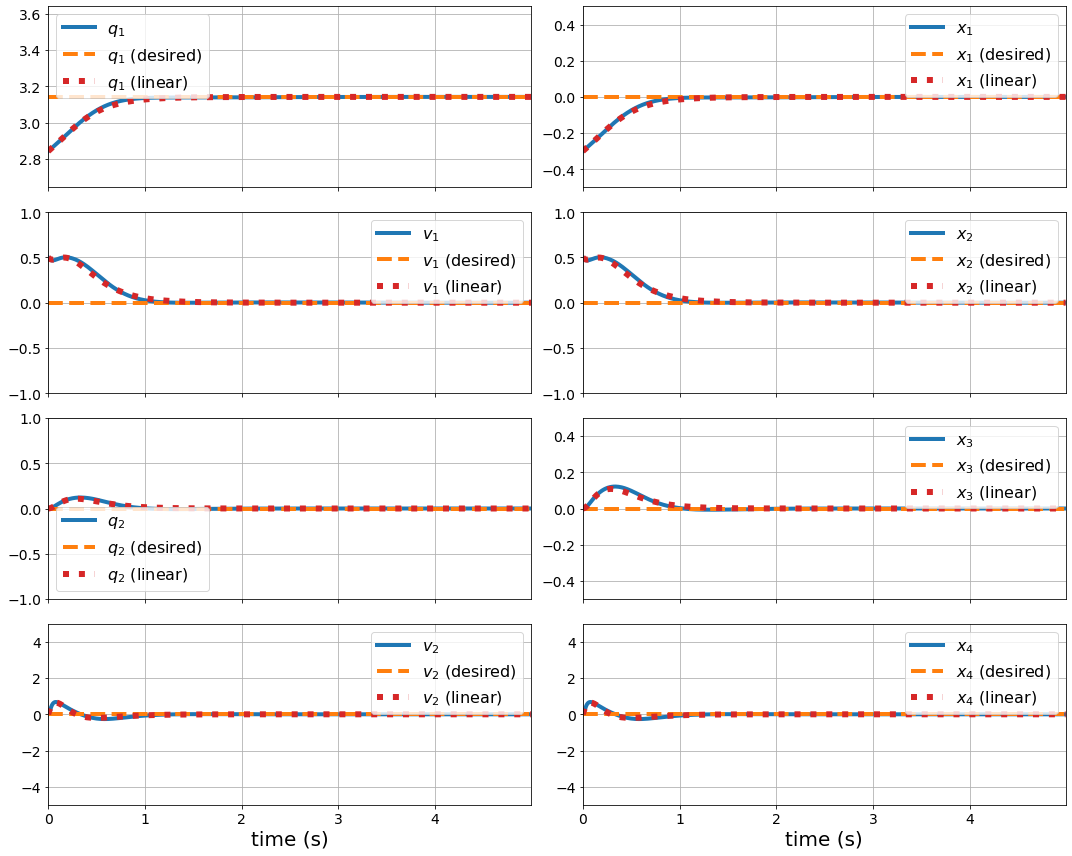

In [6]:
(q1e, v1e, q2e, v2e, taue) = (np.pi, 0., 0., 0., 0.) # <-- EQUILIBRIUM POINT (q1e = pi*integer, q2e = real, v1e = v2e = taue = 0)
(q1i, v1i, q2i, v2i) = (np.pi-0.3, 0.5, 0., 0.) # <-- INITIAL CONDITIONS

A, B = get_model(q1e, v1e, q2e, v2e, taue)

# DETERMINE MATRIX FOR LINEAR STATE FEEDBACK
p = np.array([-10., -8., -4., -2.])
fsf = signal.place_poles(A, B, p)
K = fsf.gain_matrix

K
print('Gains matrix, K =',K)

data = get_data(simulator, q1e, v1e, q2e, v2e, taue, K, q1i, v1i, q2i, v2i, max_time=5.0)
show_results(data, q1e, v1e, q2e, v2e, taue, A, B, K, q1i, v1i, q2i, v2i, show_pred=True)


## Make a plot to compare simulation results with what the state-space model predicts

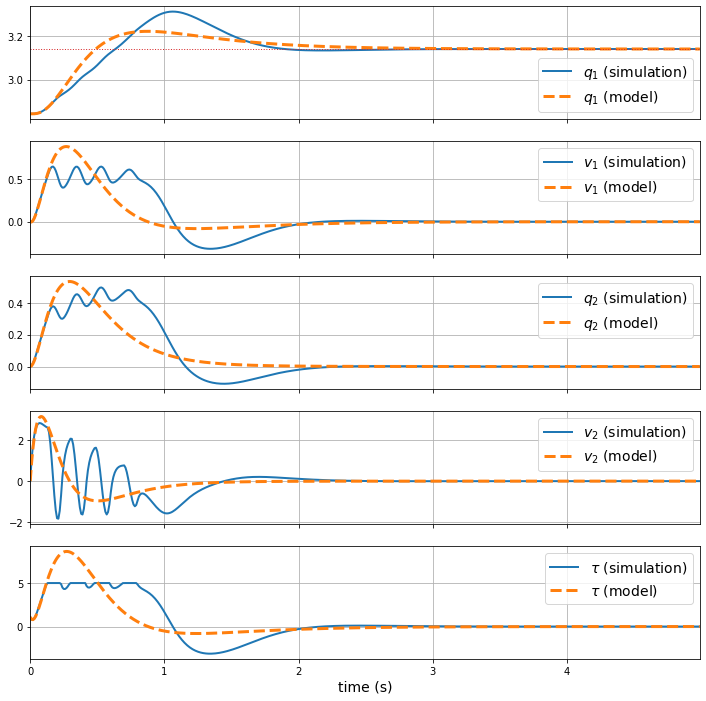

In [7]:
# Define a function to find numeric solution to closed-loop (linear) system.
def get_data_from_model(data, q1e, v1e, q2e, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
        data['gimbal_angle'][0] - q2e,
        data['gimbal_velocity'][0] - v2e,
    ])

    # Get time
    t = data['t']
    
    # Create empty array to hold state at each time
    x = np.empty((len(t), 4))
    u = np.empty((len(t), 1))

    # Compute state at each time
    for i in range(len(t)):
        x[i] = linalg.expm((A - B @ K) * t[i]) @ x0
        u[i] = - K @ x[i]
    
    # Return state and input at each time
    return x, u

(q1i, v1i, q2i, v2i) = (np.pi - 0.3, 0, 0., 0.) # <-- INITIAL CONDITIONS


# Get and parse simulation results
data = get_data(simulator, q1e, v1e, q2e, v2e, taue, K, q1i, v1i, q2i, v2i, max_time=5.0)
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
q2 = data['gimbal_angle']
v2 = data['gimbal_velocity']
tau = data['gimbal_torque']

# Get x(t) and u(t) from state-space model
x, u = get_data_from_model(data, q1e, v1e, q2e, v2e, A, B)

# Plot results
fig, (ax_q1, ax_v1, ax_q2, ax_v2, ax_tau) = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

ax_q1.plot(t, q1, '-', label='$q_1$ (simulation)', linewidth=2)
ax_q1.plot(t, x[:, 0] + q1e, '--', label='$q_1$ (model)', linewidth=3)
ax_q1.plot(t, np.pi * np.ones_like(t), ':', linewidth=1, color='C3')
ax_q1.legend(fontsize=14)
ax_q1.grid()

ax_v1.plot(t, v1, '-', label='$v_1$ (simulation)', linewidth=2)
ax_v1.plot(t, x[:, 1] + v1e, '--', label='$v_1$ (model)', linewidth=3)
ax_v1.legend(fontsize=14)
ax_v1.grid()

ax_q2.plot(t, q2, '-', label='$q_2$ (simulation)', linewidth=2)
ax_q2.plot(t, x[:, 2] + q2e, '--', label='$q_2$ (model)', linewidth=3)
ax_q2.legend(fontsize=14)
ax_q2.grid()

ax_v2.plot(t, v2, '-', label='$v_2$ (simulation)', linewidth=2)
ax_v2.plot(t, x[:, 3] + v2e, '--', label='$v_2$ (model)', linewidth=3)
ax_v2.legend(fontsize=14)
ax_v2.grid()

ax_tau.plot(t, tau, '-', label=r'$\tau$ (simulation)', linewidth=2)
ax_tau.plot(t, u[:, 0] + taue, '--', label=r'$\tau$ (model)', linewidth=3)
ax_tau.legend(fontsize=14)
ax_tau.set_xlabel('time (s)', fontsize=14)
ax_tau.set_xlim(t[0], t[-1])
ax_tau.grid()

## Make a plot to visualize the impact of varying initial conditions

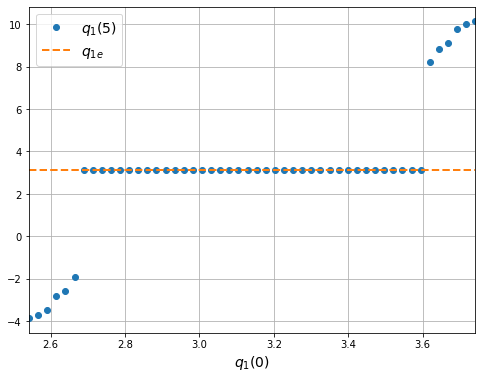

In [9]:
# Define array of initial conditions
q1i = np.linspace(q1e - 0.6, q1e + 0.6, 50)

# Define empty array to hold final conditions
q1f = np.empty_like(q1i)

# Iterate over all initial conditions
for i in range(len(q1i)):
    data = get_data(simulator, q1e, v1e, q2e, v2e, taue, K, q1i[i], v1i, q2i, v2i, max_time=5.0)
    q1f[i] = data['platform_angle'][-1] 
    
# Plot results
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

ax.plot(q1i, q1f, '.', markersize=12, label='$q_1(5)$')
ax.plot(q1i, q1e * np.ones_like(q1i), '--', linewidth=2, label='$q_{1e}$')
ax.set_xlim(q1i[0], q1i[-1])
# ax.set_ylim(np.pi-1,np.pi+1)
ax.set_xlabel('$q_1(0)$', fontsize=14)
ax.legend(fontsize=14)
ax.grid()

In [ ]:
# Determine range of valid q1i with v1i = 0
q1i_list = q1i.tolist()
q1f_list = q1f.tolist()

q1i_working = []

for q1 in q1f_list:
    if np.isclose(q1, q1e):
        q1i_working.append( q1i_list[q1f_list.index(q1)] )

print('pi -', np.pi - q1i_working[0])
print('pi +', q1i_working[-1] - np.pi)

In [ ]:
# Define array of initial conditions
v1i = np.linspace(v1e - 1.2, v1e + 1.2, 1000)

# Define empty array to hold final conditions
v1f = np.empty_like(v1i)

# Iterate over all initial conditions
for i in range(len(v1i)):
    data = get_data(simulator, q1e, v1e, q2e, v2e, taue, K, q1i, v1i[i], q2i, v2i, max_time=5.0)
    v1f[i] = data['platform_velocity'][-1] 
    
# Plot results
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

ax.plot(v1i, v1f, '.', markersize=12, label='$v_1(5)$')
ax.plot(v1i, v1e * np.ones_like(v1i), '--', linewidth=2, label='$v_{1e}$')
ax.set_xlim(v1i[0], v1i[-1])
# ax.set_ylim(-1,1)
ax.set_xlabel('$v_1(0)$', fontsize=14)
ax.legend(fontsize=14)
ax.grid()

In [ ]:
# Determine range of valid v1i with q1i = pi
v1i_list = v1i.tolist()
v1f_list = v1f.tolist()

v1i_working = []

for v1 in v1f_list:
    if np.isclose(v1, v1e,atol=1e-4):
        v1i_working.append( v1i_list[v1f_list.index(v1)] )

print(v1i_working[0])
print(v1i_working[-1])